# Solving Optimal Transport Problem with Gradient Ascent

Firstly, we should set the Optimal Transport Formulation we are working with.

Assume that we have two probability measures $\mu$ and $\nu$ defined on
a sets $X$ and $Y$ respectfully. The cost function $c : X \times Y \to \R$
defines the cost of moving a mass from a point $x \in X$ to another $y \in Y$.

One may consider the usual Kantorovich formulation:
$$
\min_{\pi \in \Pi(\mu, \nu)} \int_{X \times Y} c(x, y) \,d\pi (x, y),
$$
subject to marginal constraints for all measurable sets $A \subset X$ and $B \subset Y$:
$$
\pi(A \times Y) = \mu(A), 
\quad
\pi(X \times B) = \nu(B).
$$

In many cases, this original problem is not smooth. One common strategy is to use
the regularization technique. Another one consists of working with the dual problem
of the defined above. As we are finding the joing probability measure that minimized
the objective function, the dual problem seeks for two potentials that minimize
the other objective function:
$$
\max_{\varphi, \psi} \left\{
    \int \varphi(x) \; d\mu(x) + \int \psi(y) \; d\nu(y)
\right\},
$$
subject to
$$
\varphi(x) + \psi(y) \leq c(x, y) \quad \forall x \in X, \forall y \in Y.
$$

This dual problem __is concave__ in $\varphi$ and $\psi$.

[TODO] write gradients derivation

$$
\frac{\delta \mathcal{L}}{\delta \varphi} = \mu(x) - \int_{\mathcal{Y}} \exp \left\{
    \frac{\varphi(x) + \psi(y) - c(x, y)}{\varepsilon}
\right\} dy
$$

$$
\frac{\delta \mathcal{L}}{\delta \psi} = \nu(y) - \int_{\mathcal{X}} \exp \left\{
    \frac{\varphi(x) + \psi(y) - c(x, y)}{\varepsilon}
\right\} dx
$$

In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

from matplotlib import pyplot as plt

import sys

sys.path.append("../..")
from utils import plotting

from tqdm import tqdm
import time

In [2]:
def gradient_vanilla(
    C, a, b, eps=0.01, alpha=0.01, tolerance=1e-4, max_iterations=1_000
):
    K = jnp.exp(-C / eps)
    phi, psi = jnp.zeros_like(a), jnp.zeros_like(b)

    def objective(phi, psi, a, b, C, eps):
        return (
            jnp.dot(phi, a)
            + jnp.dot(psi, b)
            - eps * jnp.sum(jnp.exp((phi[:, None] + psi[None, :] - C) / eps))
        )

    def update_step(phi, psi):
        grad_phi = a - jnp.sum(jnp.exp((phi[:, None] + psi[None, :] - C) / eps), axis=1)
        grad_psi = b - jnp.sum(jnp.exp((phi[:, None] + psi[None, :] - C) / eps), axis=0)
        phi = phi + alpha * grad_phi
        psi = psi + alpha * grad_psi
        return phi, psi

    pbar = tqdm(range(max_iterations), desc="OT Vanilla Gradient Ascent", unit="iter")

    for iteration in pbar:
        phi_new, psi_new = update_step(phi, psi)
        # obj_value = objective(phi_new, psi_new, a, b, C, eps)
        # pbar.set_postfix(obj=obj_value)
        if (
            jnp.linalg.norm(phi_new - phi) < tolerance
            and jnp.linalg.norm(psi_new - psi) < tolerance
        ):
            break
        phi, psi = phi_new, psi_new

    plan = jnp.exp((phi[:, None] + psi[None, :] - C) / eps)

    return phi, psi, plan

/var/folders/28/l2lfqs811tv1tcy8vm_ls2140000gn/T/ipykernel_34428/2581910420.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


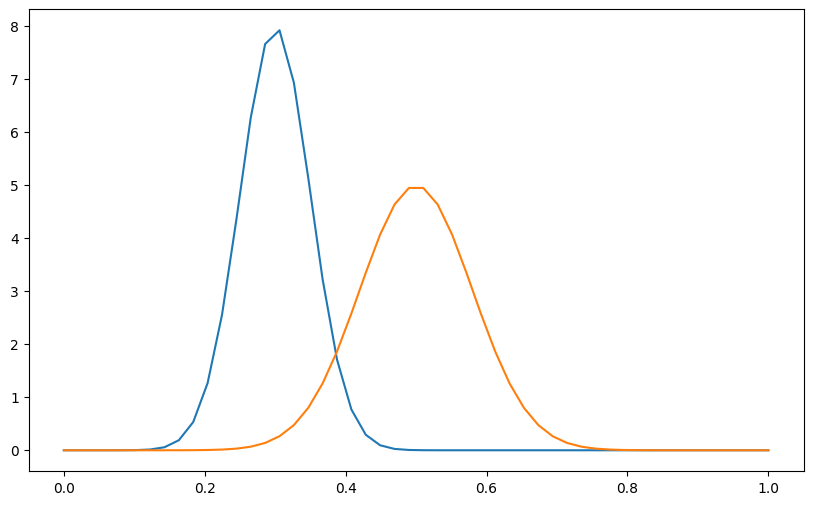

In [3]:
n = 50
x = jnp.linspace(0, 1, n)
pdf1 = jax.scipy.stats.norm.pdf(x, loc=0.3, scale=0.05)
pdf2 = jax.scipy.stats.norm.pdf(x, loc=0.5, scale=0.08)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(x, pdf1)
ax.plot(x, pdf2)
fig.show()

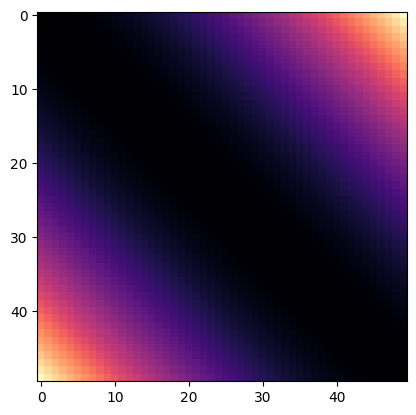

In [4]:
C = jnp.pow(x[:, None] - x[None, :], 2)

plt.imshow(C, cmap="magma")

In [5]:
final_phi, final_psi, plan = gradient_vanilla(
    C, pdf1, pdf2, eps=0.003, alpha=0.0006, tolerance=1e-4, max_iterations=30_000
)

OT Vanilla Gradient Ascent: 100%|██████████| 30000/30000 [00:30<00:00, 980.85iter/s] 


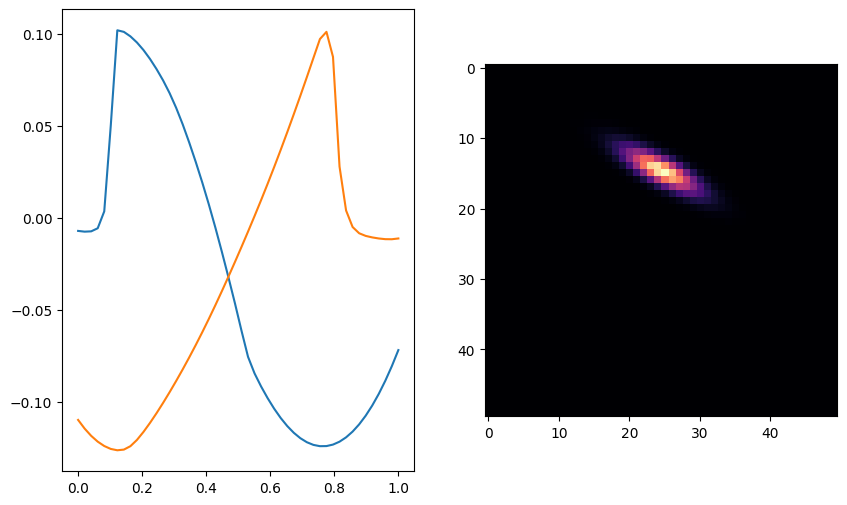

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].plot(x, final_phi)
ax[0].plot(x, final_psi)
ax[1].imshow(plan, cmap="magma")

OT Vanilla Gradient Ascent: 100%|██████████| 100000/100000 [01:28<00:00, 1134.83iter/s]


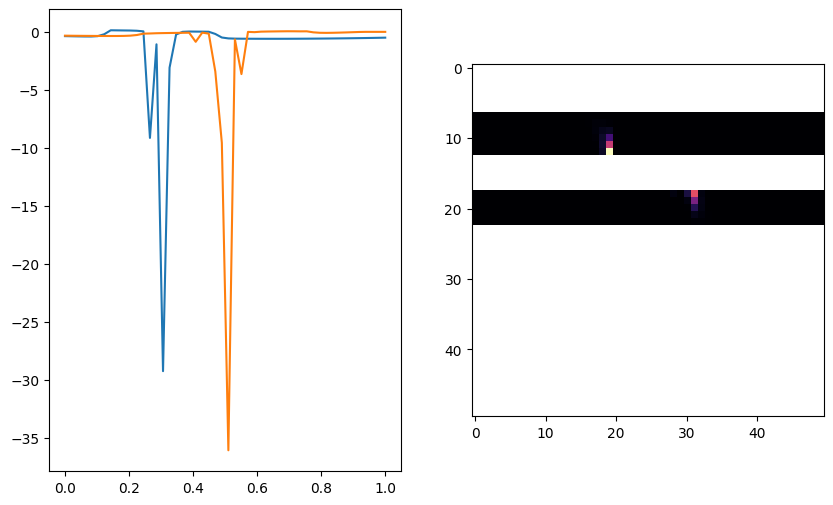

In [7]:
def gradient_vanilla_logsumexp(
    C, a, b, eps=0.01, alpha=0.1, tolerance=1e-4, max_iterations=1_000
):
    """
    Vanilla gradient ascent for entropy-regularized optimal transport (Kantorovich problem).

    Arguments:
    C -- cost matrix (n x m)
    a -- source distribution (n,)
    b -- target distribution (m,)
    eps -- entropy regularization coefficient
    alpha -- initial learning rate
    tolerance -- stopping criterion for convergence
    max_iterations -- maximum number of iterations

    Returns:
    phi, psi -- dual potentials
    plan -- optimal transport plan
    """

    n, m = C.shape
    phi, psi = jnp.zeros(n), jnp.zeros(m)  # Dual variables initialization

    def lse(phi, psi):
        """Compute the stable log-sum-exp function to avoid numerical issues."""
        return jnp.log(
            jnp.sum(jnp.exp((phi[:, None] + psi[None, :] - C) / eps), axis=1)
        )

    def compute_gradients(phi, psi):
        """Compute gradients using stabilized softmax approach."""
        log_K = (phi[:, None] + psi[None, :] - C) / eps  # Log of kernel
        log_K_max = jnp.max(log_K, axis=1, keepdims=True)  # Stabilization factor
        K_stable = jnp.exp(log_K - log_K_max)  # Stable exponentiation
        marginals = jnp.exp(log_K_max).flatten() * jnp.sum(
            K_stable, axis=1
        )  # Sum over columns
        grad_phi = a - marginals  # Compute gradient for phi

        log_K_max = jnp.max(log_K, axis=0, keepdims=True)
        K_stable = jnp.exp(log_K - log_K_max)
        marginals = jnp.exp(log_K_max).flatten() * jnp.sum(
            K_stable, axis=0
        )  # Sum over rows
        grad_psi = b - marginals  # Compute gradient for psi

        return grad_phi, grad_psi

    pbar = tqdm(range(max_iterations), desc="OT Vanilla Gradient Ascent", unit="iter")

    for iteration in pbar:
        grad_phi, grad_psi = compute_gradients(phi, psi)

        # Adaptive step size decay
        # step_size = alpha / (1 + 0.1 * iteration)
        step_size = alpha

        # Update dual variables
        phi_new = phi + step_size * grad_phi
        psi_new = psi + step_size * grad_psi

        # Convergence check
        # if (
        #     jnp.linalg.norm(grad_phi) < tolerance
        #     and jnp.linalg.norm(grad_psi) < tolerance
        # ):
        #     break
        if (
            jnp.linalg.norm(phi_new - phi) < tolerance
            and jnp.linalg.norm(psi_new - psi) < tolerance
        ):
            break
        phi = phi_new
        psi = psi_new

    phi = phi_new
    psi = psi_new

    # Compute final transport plan
    log_K = (phi[:, None] + psi[None, :] - C) / eps
    plan = jnp.exp(log_K) * (
        a[:, None] / jnp.sum(jnp.exp(log_K), axis=1, keepdims=True)
    )  # Normalized

    return phi, psi, plan


n = 50
x = jnp.linspace(0, 1, n)
pdf1 = jax.scipy.stats.norm.pdf(x, loc=0.3, scale=0.05)
pdf2 = jax.scipy.stats.norm.pdf(x, loc=0.5, scale=0.08)

C = jnp.pow(x[:, None] - x[None, :], 2)

final_phi, final_psi, plan = gradient_vanilla_logsumexp(
    C, pdf1, pdf2, eps=0.001, alpha=0.001, tolerance=1e-4, max_iterations=100_000
)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].plot(x, final_phi)
ax[0].plot(x, final_psi)
ax[1].imshow(plan, cmap="magma")

In [8]:
def gradient_vanilla_opt(
    C, a, b, eps=0.01, alpha=0.01, tolerance=1e-4, max_iterations=1_000
):
    K = jnp.exp(-C / eps)
    phi, psi = jnp.zeros_like(a), jnp.zeros_like(b)

    phi = phi[:, None]
    psi = psi[None, :]

    def compute_gradients(phi, psi):
        # u = jnp.exp(phi / eps)[:, None]
        # v = jnp.exp(psi / eps)[None, :]
        u = jnp.exp(phi / eps)
        v = jnp.exp(psi / eps)
        if jnp.any(jnp.isnan(u)) or jnp.any(jnp.isnan(v)):
            print(f"either u or v results in nan")
            print(f"{u=}")
            print(f"{v=}")
        grad_phi = a - u * jnp.sum(v * K, axis=1)
        grad_psi = b - v * jnp.sum(u * K, axis=0)
        return grad_phi, grad_psi

    pbar = tqdm(range(max_iterations), desc="OT Vanilla Gradient Ascent", unit="iter")

    for _ in pbar:
        grad_phi, grad_psi = compute_gradients(phi, psi)
        if jnp.any(jnp.isnan(grad_phi)) or jnp.any(jnp.isnan(grad_psi)):
            print(f"encountered division by zero (nan)")
            break
        phi += alpha * grad_phi
        psi += alpha * grad_psi
        if (
            jnp.linalg.norm(grad_phi) < tolerance
            and jnp.linalg.norm(grad_psi) < tolerance
        ):
            break

    # u = jnp.exp(phi / eps)[:, None]
    # v = jnp.exp(psi / eps)[None, :]
    u = jnp.exp(phi / eps)
    v = jnp.exp(psi / eps)
    plan = u * v * K
    # plan *= a / jnp.sum(plan, axis=1)

    return phi[:, 0], psi[0, :], plan

OT Vanilla Gradient Ascent:   5%|▌         | 509/10000 [00:00<00:17, 550.61iter/s]


encountered division by zero (nan)
[-0.6767176 -0.6767176 -0.6767176 -0.6767176 -0.6767176 -0.6767176
 -0.6767176 -0.6767176 -0.6767176 -0.6767176]


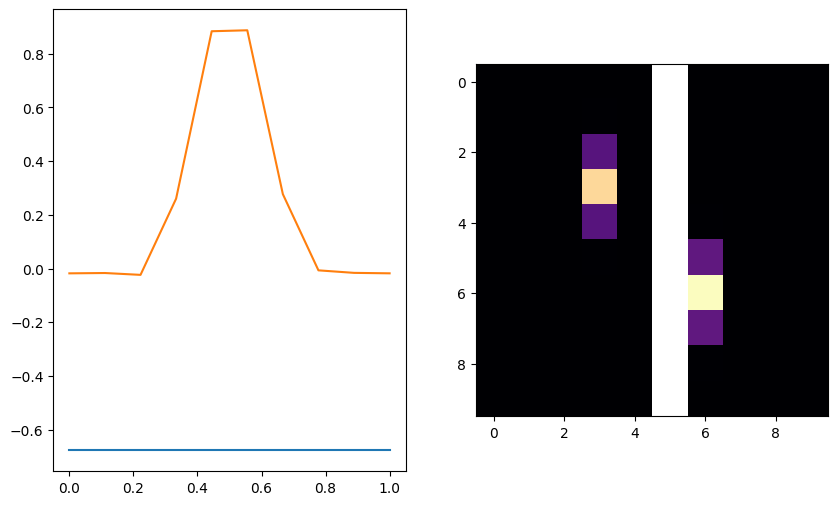

In [9]:
n = 10
x = jnp.linspace(0, 1, n)
pdf1 = jax.scipy.stats.norm.pdf(x, loc=0.3, scale=0.05)
pdf2 = jax.scipy.stats.norm.pdf(x, loc=0.5, scale=0.08)

C = jnp.pow(x[:, None] - x[None, :], 2)

final_phi, final_psi, plan = gradient_vanilla_opt(
    C, pdf1, pdf2, eps=0.01, alpha=0.001, tolerance=1e-2, max_iterations=10_000
)

print(final_phi)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].plot(x, final_phi)
ax[0].plot(x, final_psi)
ax[1].imshow(plan, cmap="magma")

In [10]:
n = 50
x = jnp.linspace(0, 1, n)
pdf1 = jax.scipy.stats.norm.pdf(x, loc=0.3, scale=0.05)
pdf2 = jax.scipy.stats.norm.pdf(x, loc=0.5, scale=0.08)

C = jnp.pow(x[:, None] - x[None, :], 2)

test_cases = [
    {
        "function": gradient_vanilla,
        "arguments": {
            "C": C,
            "a": pdf1,
            "b": pdf2,
            "eps": 0.01,
            "alpha": 0.001,
            "tolerance": 1e-4,
            "max_iterations": int(1e5),
        },
    },
    {
        "function": gradient_vanilla_logsumexp,
        "arguments": {
            "C": C,
            "a": pdf1,
            "b": pdf2,
            "eps": 0.01,
            "alpha": 0.001,
            "tolerance": 1e-4,
            "max_iterations": int(1e5),
        },
    },
]

for i, test in enumerate(test_cases):
    time_start = time.time()
    _, _, _ = test["function"](**test["arguments"])
    time_end = time.time()
    print(f"[{i}] total time {time_end - time_start} seconds")

OT Vanilla Gradient Ascent:   1%|          | 1092/100000 [00:01<01:51, 889.28iter/s]


[0] total time 1.2317981719970703 seconds


OT Vanilla Gradient Ascent:   1%|          | 1092/100000 [00:00<01:25, 1152.88iter/s]

[1] total time 0.9513111114501953 seconds


# Usage of Optax Library for Gradient Ascent Optimization

In [11]:
import optax

from jax.experimental import host_callback as hcb

In [ ]:
def gradient_ascent_opt(
    C,
    marginals,
    eps=1e-3,
    optimizer=optax.sgd,
    max_iterations=100_000,
    tol=1e-6,
) -> jax.Array:
    N = marginals.shape[0]
    n = marginals.shape[1]

    shapes = [tuple(n if j == i else 1 for j in range(N)) for i in range(N)]
    potentials = jnp.zeros_like(marginals)
    opt_state = optimizer.init(potentials)

    @jax.jit
    def objective(potentials: jax.Array):
        """Computes the dual objective with logsumexp stabilization."""
        potentials_reshaped = [potentials[i].reshape(shapes[i]) for i in range(N)]
        potentials_sum = sum(potentials_reshaped)
        log_sub_entropy = (potentials_sum - C) / eps
        max_log_sub_entropy = jnp.max(log_sub_entropy, axis=0, keepdims=True)
        stable_sum = jnp.exp(max_log_sub_entropy) * jnp.sum(
            jnp.exp(log_sub_entropy - max_log_sub_entropy), axis=0
        )
        dual = potentials * marginals
        return jnp.sum(dual - eps * stable_sum)

    @jax.jit
    def step(state: tuple[int, jax.Array, optax.OptState, float, bool]):
        """Performs one gradient ascent step."""
        i, potentials, opt_state, prev_loss, _ = state
        loss, grad = jax.value_and_grad(objective)(potentials)
        # minus gradient because we are performing gradient ascent
        updates, opt_state = optimizer.update(-grad, opt_state, potentials)
        potentials = optax.apply_updates(potentials, updates)
        # L-infinity norm
        max_change = jnp.max(jnp.abs(potentials - state[0]))
        has_converged = max_change < tol
        return i + 1, potentials, opt_state, loss, has_converged

    def cond_fn(state: tuple[int, jax.Array, optax.OptState, float, bool]):
        i, _, _, _, has_converged = state
        return jnp.logical_and(i < max_iterations, jnp.logical_not(has_converged))

    final_state = jax.lax.while_loop(
        cond_fn, step, (0, potentials, opt_state, jnp.inf, False)
    )

    steps, final_potentials, _, final_loss, _ = final_state
    print(f"DualOT Gradient Ascent has converged after {steps} steps")
    return final_potentials

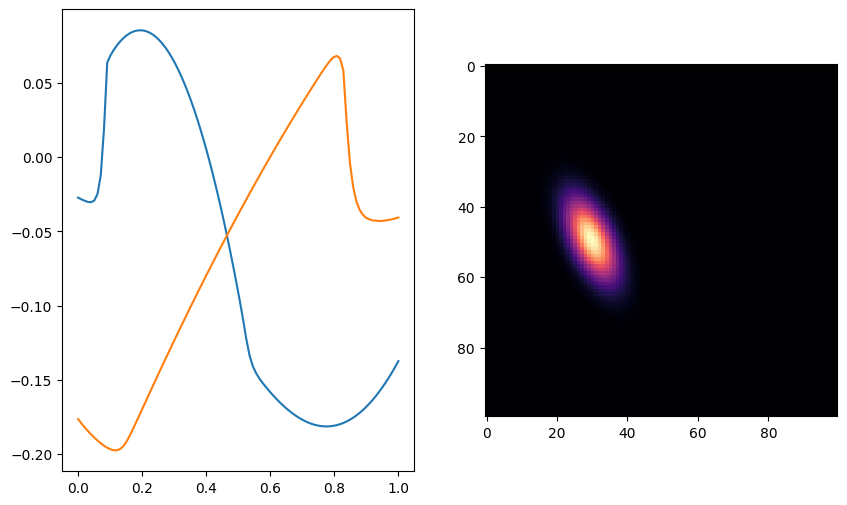

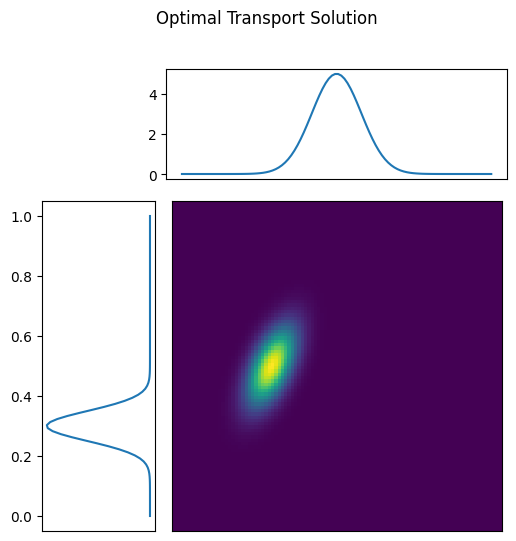

In [14]:
n = 100
x = jnp.linspace(0, 1, n)
pdf1 = jax.scipy.stats.norm.pdf(x, loc=0.3, scale=0.05)
pdf2 = jax.scipy.stats.norm.pdf(x, loc=0.5, scale=0.08)

C = jnp.pow(x[:, None] - x[None, :], 2)

eps = 0.01

final_potentials = gradient_ascent_opt(
    C=C,
    marginals=jnp.array([pdf1, pdf2]),
    eps=eps,
    optimizer=optax.sgd(learning_rate=1e-3),
    max_iterations=100_000,
    tol=1e-8,
)

transport_plan = jnp.exp(
    (final_potentials[0][None, :] + final_potentials[1][:, None] - C) / eps
)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].plot(x, final_potentials[0])
ax[0].plot(x, final_potentials[1])
ax[1].imshow(transport_plan, cmap="magma")

plotting.plot_ot_solution(x, pdf1, pdf2, transport_plan)

In [15]:
def compute_dual_entropic_ot_loss(potentials, C, marginals, eps):
    """
    Computes the dual objective (loss) for the entropic optimal transport problem.

    Args:
        potentials: JAX array of shape (N, n) representing the dual potentials.
        C: JAX array of shape (n, n, ..., n) with N dimensions (cost matrix).
        marginals: JAX array of shape (N, n) containing the marginal constraints.
        eps: Regularization coefficient (entropy weight).

    Returns:
        loss: The computed dual objective value.
    """
    N, n = marginals.shape
    shapes = [tuple(n if j == i else 1 for j in range(N)) for i in range(N)]

    potentials_reshaped = [potentials[i].reshape(shapes[i]) for i in range(N)]
    potentials_sum = sum(potentials_reshaped)

    log_sub_entropy = (potentials_sum - C) / eps

    max_log_sub_entropy = jnp.max(log_sub_entropy, axis=0, keepdims=True)
    stable_sum = (
        jnp.log(jnp.sum(jnp.exp(log_sub_entropy - max_log_sub_entropy), axis=0))
        + max_log_sub_entropy
    )

    dual = potentials * marginals
    loss = jnp.sum(dual - eps * stable_sum)

    return loss


def compute_transport_plan(potentials, C, marginals, eps):
    """
    Computes the optimal transport plan given potentials, cost matrix, and marginals.

    Args:
        potentials: JAX array of shape (N, n) representing dual potentials.
        C: JAX array of shape (n, n, ..., n) with N dimensions (cost matrix).
        marginals: JAX array of shape (N, n) containing the marginal constraints.
        eps: Regularization coefficient (entropy weight).

    Returns:
        plan: JAX array of shape (n, n, ..., n) representing the transport plan.
    """
    N, n = marginals.shape
    shapes = [tuple(n if j == i else 1 for j in range(N)) for i in range(N)]

    potentials_reshaped = [potentials[i].reshape(shapes[i]) for i in range(N)]
    potentials_sum = sum(potentials_reshaped)

    log_K = (potentials_sum - C) / eps

    exp_log_K = jnp.exp(log_K)

    plan = exp_log_K
    for i in range(N):
        plan *= marginals[i].reshape(shapes[i]) / jnp.sum(
            exp_log_K, axis=i, keepdims=True
        )

    return plan

OT Vanilla Gradient Ascent:   1%|▏         | 1496/100000 [00:01<01:47, 912.32iter/s] 


Dual Entropic OT Loss for direct gradient method is 8.451054
Dual Entropic OT Loss for optax gradient method is 13.321122
L^inf norm of the potentials is 0.097825


Text(0.5, 1.0, 'Transport Plan (Optax)')

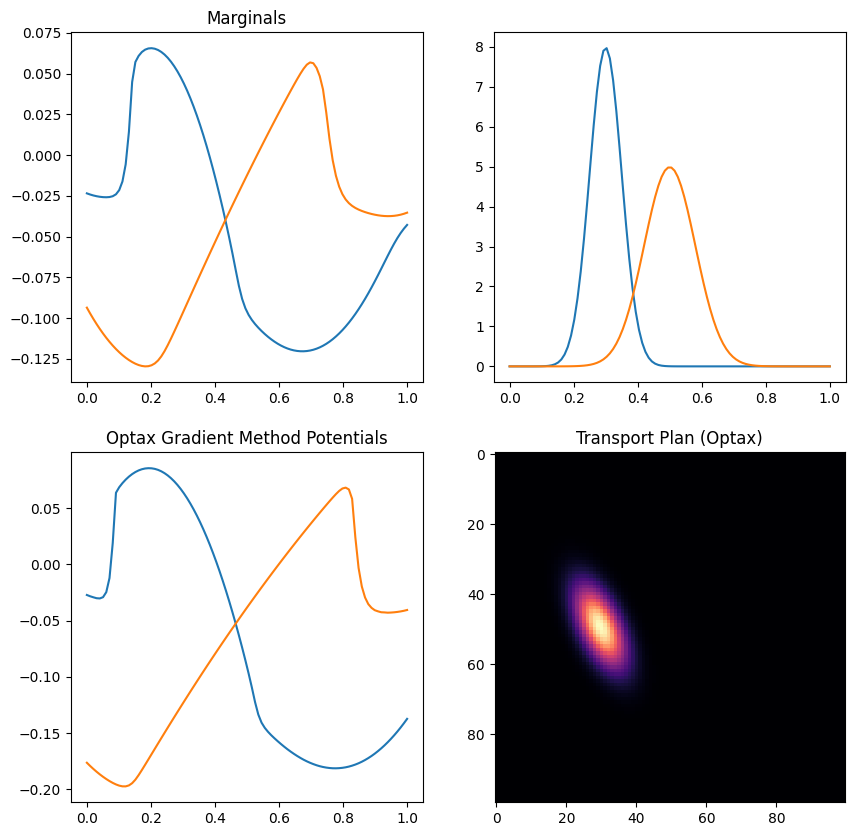

In [18]:
n = 100
x = jnp.linspace(0, 1, n)
pdf1 = jax.scipy.stats.norm.pdf(x, loc=0.3, scale=0.05)
pdf2 = jax.scipy.stats.norm.pdf(x, loc=0.5, scale=0.08)

marginals = jnp.array([pdf1, pdf2])

C = jnp.pow(x[:, None] - x[None, :], 2)

eps = 0.01
tol = 1e-4
max_iterations = 100_000

direct_phi, direct_psi, direct_plan = gradient_vanilla_logsumexp(
    C=C,
    a=pdf1,
    b=pdf2,
    eps=eps,
    alpha=1e-3,
    tolerance=tol,
    max_iterations=max_iterations,
)
direct_potentials = jnp.array([direct_phi, direct_psi])

opt_potentials = gradient_ascent_opt(
    C=C,
    marginals=marginals,
    eps=eps,
    optimizer=optax.sgd(learning_rate=1e-3),
    max_iterations=max_iterations,
    tol=tol,
)
opt_plan = compute_transport_plan(opt_potentials, C, marginals, eps)

direct_loss = compute_dual_entropic_ot_loss(direct_potentials, C, marginals, eps)
opt_loss = compute_dual_entropic_ot_loss(opt_potentials, C, marginals, eps)

print(f"Dual Entropic OT Loss for direct gradient method is {direct_loss:.6f}")
print(f"Dual Entropic OT Loss for optax gradient method is {opt_loss:.6f}")

linf_potentials_norm = jnp.max(jnp.abs(direct_potentials - opt_potentials))
print(f"L^inf norm of the potentials is {linf_potentials_norm:.6f}")

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].plot(x, direct_phi)
ax[0][0].plot(x, direct_psi)
ax[0][0].set_title("Direct Gradient Method Potentials")
ax[0][1].plot(x, pdf1)
ax[0][1].plot(x, pdf2)
ax[0][0].set_title("Marginals")
ax[1][0].plot(x, opt_potentials[0])
ax[1][0].plot(x, opt_potentials[1])
ax[1][0].set_title("Optax Gradient Method Potentials")
ax[1][1].imshow(transport_plan, cmap="magma")
ax[1][1].set_title("Transport Plan (Optax)")

# plotting.plot_ot_solution(x, pdf1, pdf2, transport_plan)